In [0]:
spark.conf.set(
    
)


In [0]:
import json
import time
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

df_train = spark.read.parquet("abfss://lakehouse@lab5mri.dfs.core.windows.net/gold/train.parquet").toPandas()
df_test  = spark.read.parquet("abfss://lakehouse@lab5mri.dfs.core.windows.net/gold/test.parquet").toPandas()

print("Train:", df_train.shape)
print("Test:", df_test.shape)


Train: (202, 86)
Test: (51, 86)


In [0]:
data = spark.read.text("abfss://lakehouse@lab5mri.dfs.core.windows.net/gold/selected_features.json")
selected_features = json.loads(data.collect()[0][0])


In [0]:
X_train = df_train[selected_features]
y_train = df_train['label']

X_test = df_test[selected_features]
y_test = df_test['label']

X_train.shape, X_test.shape


((202, 34), (51, 34))

In [0]:
start = time.time()

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42
)
model.fit(X_train, y_train)

train_time = time.time() - start
train_time


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

5.9052510261535645

In [0]:
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
acc


0.6862745098039216

In [0]:
import json

metrics = {
    "test_accuracy": float(acc),
    "num_features_used": len(selected_features),
    "training_time_seconds": float(train_time)
}

# Convert dict → JSON string
metrics_json = json.dumps(metrics, indent=4)

# Save to DBFS
dbutils.fs.put("dbfs:/FileStore/metrics.json", metrics_json, overwrite=True)

metrics


Wrote 121 bytes.


{'test_accuracy': 0.6862745098039216,
 'num_features_used': 34,
 'training_time_seconds': 5.9052510261535645}

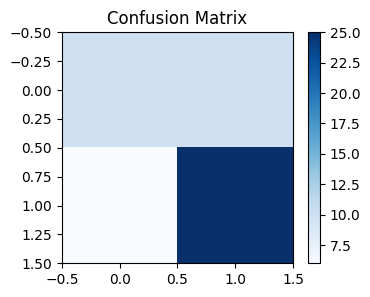

In [0]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,3))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

# Save correctly in DBFS
plt.savefig("/dbfs/FileStore/confusion_matrix.png")

plt.show()


In [0]:
import pickle

model_path = "/dbfs/FileStore/final_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(model, f)

print("Model saved at:", model_path)


Model saved at: /dbfs/FileStore/final_model.pkl


In [0]:
display(dbutils.fs.ls("dbfs:/FileStore"))


path,name,size,modificationTime
dbfs:/FileStore/confusion_matrix.png,confusion_matrix.png,17209,1764444586000
dbfs:/FileStore/final_model.pkl,final_model.pkl,442166,1764444746000
dbfs:/FileStore/metrics.json,metrics.json,121,1764444508000


In [0]:
display(dbutils.fs.ls("FileStore"))


path,name,size,modificationTime
dbfs:/FileStore/confusion_matrix.png,confusion_matrix.png,17209,1764444586000
dbfs:/FileStore/final_model.pkl,final_model.pkl,442166,1764444746000
dbfs:/FileStore/metrics.json,metrics.json,121,1764444508000


In [0]:
# Helper function to create a downloadable link inside Databricks
def make_download_link(dbfs_path, download_name):
    local_path = f"/tmp/{download_name}"
    dbutils.fs.cp(dbfs_path, f"file:{local_path}")
    return f"Download → /files/{download_name}"

links = {
    "confusion_matrix.png": make_download_link("dbfs:/FileStore/confusion_matrix.png", "confusion_matrix.png"),
    "final_model.pkl": make_download_link("dbfs:/FileStore/final_model.pkl", "final_model.pkl"),
    "metrics.json": make_download_link("dbfs:/FileStore/metrics.json", "metrics.json"),
}

links


{'confusion_matrix.png': 'Download → /files/confusion_matrix.png',
 'final_model.pkl': 'Download → /files/final_model.pkl',
 'metrics.json': 'Download → /files/metrics.json'}

In [0]:
from IPython.display import HTML

def download_link(dbfs_path, label):
    # copy file from DBFS → local driver
    local_path = f"/tmp/{label}"
    dbutils.fs.cp(dbfs_path, f"file:{local_path}")

    # return real clickable HTML link
    return f'<a href="/files/{label}" download>{label} ⬇️</a>'

html = """
<h3>Download Your Files</h3>
<ul>
  <li>{}</li>
  <li>{}</li>
  <li>{}</li>
</ul>
""".format(
    download_link("dbfs:/FileStore/confusion_matrix.png", "confusion_matrix.png"),
    download_link("dbfs:/FileStore/final_model.pkl", "final_model.pkl"),
    download_link("dbfs:/FileStore/metrics.json", "metrics.json"),
)

HTML(html)
